# Graph creation

## k-NN graph
In a k-NN graph each vertex $v_i$ is connected with $v_j$ if $v_j$ is  among the k-nearest neighbors of $v_i$.

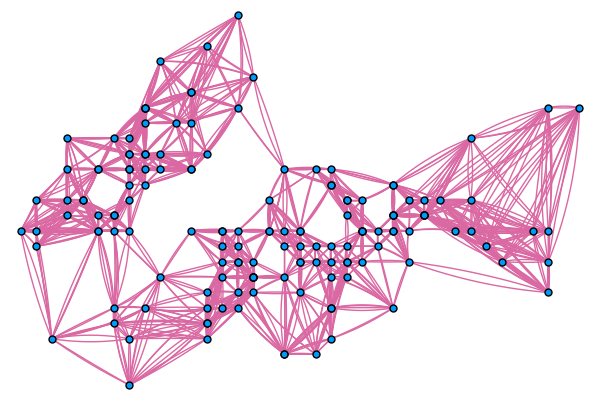

In [2]:
using Plots 
using RDatasets
using SpectralClustering
using Distances
using GraphRecipes
pyplot()
function weight(i::Integer, neigh, v, m)
    return exp.(-Distances.colwise(SqEuclidean(),m,v)./(20))
end
d = dataset("datasets", "iris");
d = convert(Matrix,d[:,1:2])';
knnconfig = KNNNeighborhood(d,10);
graph = create(knnconfig,weight,d);
plt = graphplot(graph, markersize=5, func=(source;kw...)->fixed_layout(d, source))

## k-NN locally scaled graph

Instead of selecting a single scaling parameter $\alpha$, [this method](#Zelnik-manor04self-tuningspectral) calculates  a  local  scaling  parameter $\alpha_i$ for  each  data  point $s_i$. The  distance  from $s_i$ to $s_j$ as  ‘seen’  by $s_i$ is $\frac{d(s_i,s_j)}{\alpha_i}$ while  the  converse  is $\frac{d(s_j,s_i)}{\alpha_j}$.   Therefore  the square distance $d^2$ may be generalized as $\frac{d(s_i,s_j)d(s_j,s_i )}{\alpha_i \alpha_j}=\frac{d^2(s_i,s_j)}{\alpha_i \alpha_j}$. The affinity between a pair of points can thus be written as

$W_{ij} = \exp\left(  \frac{-d^2(s_i,s_j)}{\alpha_i \alpha_j  } \right)$

Using a specific scaling parameter for each point allows self-tuning of the point-to-point distances according to the local statistics of the neighborhoods surrounding points $i$ and $j$. The selection of the local scale $\alpha_i$ can be done by studying the local statistics of the neighborhood of point $s_i$.   A simple choice [made by the authors](#Zelnik-manor04self-tuningspectral) is:

$\alpha_i = d(s_i, s_K)$

where $s_K$ is the $K$’th neighbor of point $s_i$.  The selection of $K$ is independent of scale and is a function of the data dimension of the embedding space.  Zelnik-Manor and Perona uses $K=7$


In [ ]:
using Plots # hide
gr() # hide
using RDatasets
using SpectralClustering
using Distances
using LinearAlgebra
using GraphRecipes
function weight(i::Integer, neigh, v, m)
    return exp.(-Distances.colwise(SqEuclidean(),m,v)./(l_scale[i].*l_scale[neigh]))
end
d = dataset("datasets", "iris")
d = convert(Matrix,d[:,1:2])'
knnconfig = KNNNeighborhood(d,10)
l_scale = local_scale(knnconfig, (v1,v2)->norm(v1-v2),  d  )
graph = create(knnconfig,weight,d);
plt = graphplot(graph, markersize=5, func=(source;kw...)->fixed_layout(d, source))

## Simmilarity graph from an image
Given an image It is possible build a simmilarity graph considering every pixel as a vertex.
A pixel  has an spatial position and a color component $(x,y,r,g,b)$. The following example creates a simmilarity graph in wich two pixels, $p_1=(x_1,y_1,r_1,g_1,b_1)$ and $p_2 =(x_2,y_2,r_2,g_2,b_2)$ are connected if $ \vert \vert (x_1,y_1) - (x_2,y_2) \vert \vert_2 \leq 7$.
Every edge is weighted according:

$ W_{ij}=  \exp\left(\frac{ \vert \vert [r_1,g_1,b_1]-[r_2,g_2,b_2] \vert \vert}{2 \cdot 0.5^2} \right) $

In [ ]:
using Distances, Images, FileIO, TestImages , SpectralClustering
function w(i::Integer, j::Vector{<:Integer}, pixel_j::Vector, neighbors_data::Matrix)
    col_sim = exp.(-(Distances.colwise(SqEuclidean(),pixel_j[3:5], neighbors_data[3:5,:])) / (2*(0.6^2)))
    return col_sim
end
img = testimage("mandrill")
img = imresize(img, round.(Integer,size(img).*0.2))
nconfig = PixelNeighborhood(11)
graph = create(nconfig,w, img);

### Output

In [ ]:
using Plots, Measures, Colors
res = zeros(size(img));
pixels_r = [20, 30, 70]
pixels_c = [20, 60, 55]
for idx_vertex in LinearIndices(img)[[20, 30, 70], [20,60,55]]
    vertex = graph.vertices[idx_vertex] 
    for edge in vertex # hide
        t_vertex = target_vertex(edge, vertex) 
        res[t_vertex.id] = edge.weight 
    end 
end 
res = RGB.(Gray.(imadjustintensity(res)))
setindex!.((res, ), RGB(1.0,0.0,0.0), pixels_r, pixels_c)
plt1 = Plots.plot(img, title="Original image", top_margin=10mm)
plt2 = Plots.plot(res, title="Simmilarity computed\nfor three pixels", top_margin=10mm)
Plots.plot(plt1,plt2, layout =( @layout grid(1,2)))